# Analysis of Urban-Traffic Simulated Data – part II
##### Ruggero Fabbiano – 13 January 2021

## Introduction

As the title says itself, this notebook is intended as a prosecution of the Analysis of Urban-Traffic Simulated Data – part I. While in this previous notebook we did some exploratory data analysis to get an understanding the data and of its basic population statistics, here we delve into some analysis about the traffic conditions.
    
The dataset is of the same type of the one used in part I; moreover, we assume it to have already gone through the Data Cleaning step of part I. The scenario is still the same (MoST), but this time the selected interval is from 6 to 8:30 AM, so as to have richer traffic conditions.

For further introduction, refer to part I, that can be found in the same GitHub repository.

 ***

## Import Packages and Data

Let's be sure we have all the necessary packages installed:

In [1]:
!pip install matplotlib
!pip install numpy
!pip install pandas

We can now import them:

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from datetime import timedelta, datetime, time

plt.style.use('bmh')

Now to the data. We choose here the set spanning from 6 to 8:30 AM, to have some free flow as well as congested traffic conditions:

In [3]:
out_file = 'most_0600_0830_1_5.csv'

As explained in the introduction, we suppose to have previously run the part-I notebook with the same data set, thus we have it already available in its compact form (_i.e._, as the dataframe is saved after the part-I "Data Cleaning" chapter).

In [4]:
out_file_clean = out_file.split(".")[0] + "-clean" + ".csv"
data = pd.read_csv(out_file_clean, low_memory=False)

data.head()

,t,angle,ID,lane_edge,position,slope,speed,v_type,x,y,z,time
0,21600.0,74.69,France:Italy.0,152525#0_0,7.2,3.42,0.0,hw_truck,66.77,2975.61,385.23,06:00:00
1,21600.0,171.94,Italy:France.0,152272_0,5.1,0.84,0.0,hw_passenger2b,7023.41,6356.52,280.47,06:00:00
2,21600.0,50.48,pedestrian_2-1_3985_tr,153330#1_1,2.2,-1.57,0.0,moped,4811.50,2704.21,143.81,06:00:00
3,21600.0,50.48,pedestrian_2-1_3985,153330#1,2.20,-1.55,0.00,NaN,4811.50,2704.21,143.81,06:00:00
4,21600.0,307.42,pedestrian_2-1_5063_tr,152413#3_1,2.3,-6.20,0.0,motorcycle,2006.06,3313.49,400.40,06:00:00


Now, before being able to infer meaningful information about traffic conditions, it is probably helpful to explore the different vehicle types.

## Preliminary: Feature Engineering on the Vehicle Type

We might start off by dropping all the pedestrians, that won't probably be of much help in understanding traffic. Anyway let's just keep them for the moment, to see if they allow us some interesting comparisons (we can always drop them later); so, let's create a type for pedestrians as well:

In [5]:
data['v_type'].fillna('pedestrian', inplace=True) # pedestrians have no vehicle type
data.rename(columns={'v_type': "type"}, inplace=True) # "type" is not prerogative of vehicles anymore

Now let's check which types we have:

In [6]:
np.sort(data['type'].unique())

array(['army', 'authority', 'avgbicycle', 'bus', 'coach', 'delivery',
       'emergency', 'fastbicycle', 'hw_coach', 'hw_delivery',
       'hw_motorcycle', 'hw_passenger1', 'hw_passenger2a',
       'hw_passenger2b', 'hw_passenger3', 'hw_passenger4', 'hw_trailer',
       'hw_truck', 'moped', 'motorcycle', 'passenger1', 'passenger2a',
       'passenger2b', 'passenger3', 'passenger4', 'pedestrian',
       'slowbicycle', 'taxi', 'trailer', 'train', 'truck', 'uber'],
      dtype=object)

Before further reasoning on the different types, we can probably use a bit of manual regrouping to make things easier. To understand the different types, we can refer to two useful tables in the SUMo documentation:
* the [SUMo definition of abstract vehicle classes](https://sumo.dlr.de/docs/Definition_of_Vehicles,_Vehicle_Types,_and_Routes.html#abstract_vehicle_class);
* the [SUMo vehicle-type parameters](https://sumo.dlr.de/docs/Vehicle_Type_Parameter_Defaults.html);

as well as two files that define specific types for the MoST scenario:
* `MoST_scenario\scenario\in\add\basic.vType.xml`;
* `MoST_scenario\scenario\in\route\most.highway.flows.xml`.

These files are in the MoST repository, that we forked and used to [generate data in a reproducible way](https://github.com/pgrandinetti/standard-traffic-data/blob/main/std_traffic/pipelines/Dockerfile.sumoToAws).

Based on all of these sources, we can make the following considerations:
* `army` and `authority` are abstract SUMo classes that have no specific parameter definition, and in MoST they are all grouped together with `emergency` vehicles;
* `avgbicycle`, `fastbicycle` and `slowbicycle` are 3 different MoST-specific types of bicycles (with speed centered around the SUMo `bicycle` class' speed);
* `coach` is supposed to be an overland person transportation mean, but is defined as a goods transport in MoST: maybe a mistake, we can probably drop it;
* all vehicles starting with `hw_` are a MoST definition for vehicles running on motorways: definitely not fit for _urban_ traffic analysis;
* vehicles starting with `passenger` represent in MoST different shapes of "plain" passenger cars;
* `trailer` is just a variation of `truck`;
* `train` is surely not interesting for traffic analysis;
* `uber` is defined in MoST but represents the same concept as `taxi`.

Based on the considerations above, we can first drop coaches, motorways vehicles and trains; let's just print before that what percentage of the data they represent:

In [7]:
N = len(data['ID'].unique())
n_c = len(data[data['type']=='coach']['ID'].unique())
n_t = len(data[data['type']=='train']['ID'].unique())
n_HW = len(data[data['type'].apply(lambda x: x.startswith('hw_'))]['ID'].unique())

print(F"Representation of total number of vehicles: {(n_c+n_t+n_HW)/N:.2%}")
print(F"Coaches: {n_c/N:.2%}\t\tTrains: {n_t/N:.2%}\t\tMotorway vehicles: {n_HW/N:.2%}")

Representation of total number of vehicles: 1.96%
Coaches: 0.41%		Trains: 0.04%		Motorway vehicles: 1.51%


OK, let's drop them:

In [8]:
not_coach = data['type']!='coach'
not_motorway = data['type'].apply(lambda x: not x.startswith('hw_'))
not_train = data['type']!='train'

data = data[not_coach & not_motorway & not_train]

Now we can group the remaining vehicles as discussed before:

In [9]:
redefine_types = lambda v_type: "special" if v_type in ['army', 'authority', 'emergency'] else (
    "bicycle" if v_type.endswith('bicycle') else (
        "car" if v_type.startswith('passenger') else (
            "lorry" if v_type in ['trailer', 'truck'] else (
                "hire" if v_type in ['taxi', 'uber'] else v_type
            )
        )
    )
)
data['type'] = data['type'].map(redefine_types)

np.sort(data['type'].unique())

array(['bicycle', 'bus', 'car', 'delivery', 'hire', 'lorry', 'moped',
       'motorcycle', 'pedestrian', 'special'], dtype=object)

Better. Now we can do some further analysis based on their speed; to do so, we have to convert speed to numeric first:

In [10]:
def process_speed(v):
    try: return float(v)*3.6
    except ValueError: return np.NaN # we might have abnormal values

data['speed'] = data['speed'].map(process_speed) # numeric in km/h from m/s

Let's check for invalid speeds:

In [11]:
invalid_objects = data[data['speed'].isna()]['ID'].unique()
invalid_objects

array(['pedestrian_1-1-pt_5659', 'pedestrian_1-1-pt_4742',
       'pedestrian_1-GW2_388', 'pedestrian_1-1-pt_3735',
       'pedestrian_1-1-pt_6941', 'pedestrian_1-GW1_409',
       'pedestrian_1-GW1_745', 'pedestrian_1-GW2_1070',
       'pedestrian_GW1-1_3372'], dtype=object)

Indeed there are, but they're fortunately very few; let's drop them:

In [12]:
data = data[~data['ID'].isin(invalid_objects)]

Now let's look at speed by type.
Let's do the grouping:

In [13]:
grouped = data.groupby('type')['speed']
speed_by_type = pd.DataFrame({"v_mean": grouped.mean(), "v_max": grouped.max()})
speed_by_type["v_ratio"] = speed_by_type.apply(lambda x: 100*x[0]/x[1], axis=1)

And now let's see if the barplot tells us something useful:

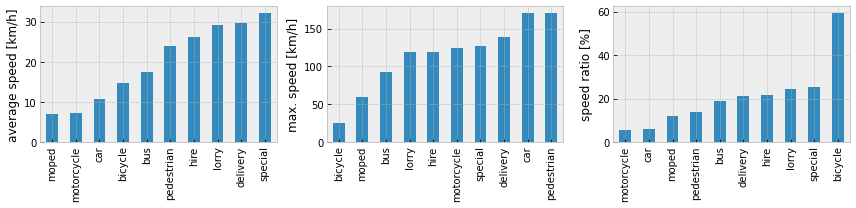

In [14]:
labels = ["average speed [km/h]", "max. speed [km/h]", "speed ratio [%]"]

fig, axes = plt.subplots(nrows=1, ncols=3)
for i,col in enumerate(speed_by_type.columns):
    speed_by_type[col].sort_values().plot.bar(ax=axes[i], figsize=(12,3), xlabel="", ylabel=labels[i])

plt.tight_layout()

We can already see some very interesting trend!
* The average speed graph tells us that car have lower average speed than bicycles! While being very interesting, this is probably inherent to the traffic condition itself more than an "unexpected behaviour".
* The max. speed (graph 2) looks more or less as expected, expect for the fact that... pedestrians are the fastest objects overall! There sure must be something wrong about pedestrians in the dataset. Looking at pedestrian definition in SUMo and the speed deviation defined in MoST, they should definitely not exceed (quite obviously) 8 km/h of speed!
* Finally, looking at the speed ratio it looks like bicycles are by far the less affected by traffic.

This last point can be taken care of quite easily: it is probably better to drop bicycles, because they are less sensible to traffic congestions and thus not very useful to analyse them. The same conclusion can probably be drawn for buses for the opposite reason: they stop continuously, thus making hard to use their behaviour to interpret traffic. This can indeed explain a low speed ratio even with a relatively low maximum speed.

#### Save the data on-file

Before dropping objects anyway, let us save the processed dataset; it might be useful in future analyses.

We use the Pandas built-in `pickle` type here, but you might want to check out also `feather` or `parquet` for better performances.

In [15]:
data.to_pickle("MoST_0600_0830_processed.pkl")

#### Back to the analysis

Now we can get drop bicycles and buses:

In [16]:
data = data[(data['type']!='bicycle') & (data['type']!='bus')]

We might as well get rid of pedestrians, but we may lose a lot of data doing so; let's check how many they are:

In [17]:
N = len(data['ID'].unique())
n_p = len(data[data['type']=='pedestrian']['ID'].unique())
print(F"{n_p} pedestrians, {n_p/N:.2%} of total number of objects")

19526 pedestrians, 52.53% of total number of objects


They are the majority! Probably they hide some other type of vehicle? Better try to work on them than directly drop them.
We know that when a pedestrian catches a transportation mean (_e.g._, a bus), a corresponding object with the same ID with suffix `_tr` is created. We can try to infer the type from the this corresponding object: maybe there's some kind of bug in pedestrians handling?

In [18]:
grouped = data.groupby('ID')['type']
ped = grouped.min().filter(like='pedestrian', axis=0)

# sanity check: verify that each "_tr" object has always the same type along time)
assert ped.equals(grouped.max().filter(like='pedestrian', axis=0))

def reassign_ped(ID_type):
    if ID_type[1]=='pedestrian':
        try: return ped.loc[ID_type[0]+'_tr']+" (P)"
        except KeyError: return 'pedestrian'
    else: return ID_type[1]

data['type_proc'] = data[['ID', 'type']].apply(reassign_ped, axis=1)

Now let's regroup the speed by type and plot it again:

In [19]:
grouped = data.groupby('type_proc')['speed']
speed_by_type = pd.DataFrame({"v_mean": grouped.mean(), "v_max": grouped.max()})
speed_by_type["v_ratio"] = speed_by_type.apply(lambda x: 100*x[0]/x[1], axis=1)

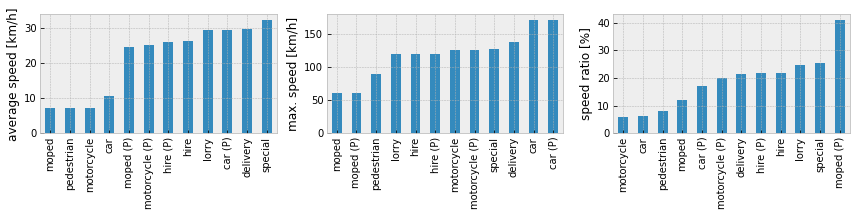

In [20]:
labels = ["average speed [km/h]", "max. speed [km/h]", "speed ratio [%]"]

fig, axes = plt.subplots(nrows=1, ncols=3)
for i,col in enumerate(speed_by_type.columns):
    speed_by_type[col].sort_values().plot.bar(ax=axes[i], figsize=(12,3), xlabel="", ylabel=labels[i])

plt.tight_layout()

We can observe that the maximum speed reached by the new types is extremely close to that of the corresponding original type: maybe our guess was correct? The average speed is slightly higher, but this is a statistical parameter thus depending on the population (while the max. speed is more related to the specific type).
On the other hand, "pure" pedestrians still reach still a speed of around 90 km/h! We can probably now merge the types here obtained with their corresponding:

In [21]:
data['type_p'] = data['type_proc'].map(lambda x: x.split(' ')[0])
data.drop('type_proc', axis=1, inplace=True)

Let's save the dataset obtained (we might want to use it in future works) before continuing:

In [22]:
data.to_pickle("ped_reclassified.pkl")

And now drop the pedestrians left:

In [23]:
n_ped = len(data[data['type_p']=='pedestrian']['ID'].unique())
print(F'{n_ped} "true" pedestrians, {n_ped/n_p:.2%} of total pedestrians')

data = data[data['type_p']!='pedestrian']

3916 "true" pedestrians, 20.06% of total pedestrians


Let's plot the speed by type a last time to check what it looks like now:

In [24]:
grouped = data.groupby('type_p')['speed']
speed_by_type = pd.DataFrame({"v_mean": grouped.mean(), "v_max": grouped.max()})
speed_by_type["v_ratio"] = speed_by_type.apply(lambda x: 100*x[0]/x[1], axis=1)

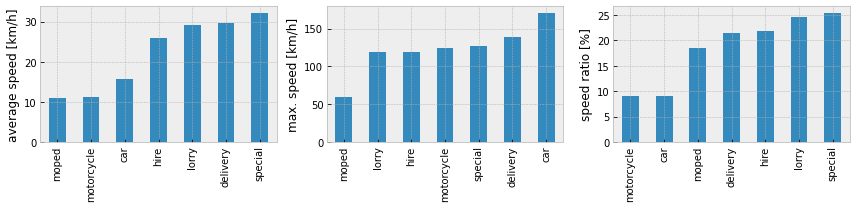

In [25]:
labels = ["average speed [km/h]", "max. speed [km/h]", "speed ratio [%]"]

fig, axes = plt.subplots(nrows=1, ncols=3)
for i,col in enumerate(speed_by_type.columns):
    speed_by_type[col].sort_values().plot.bar(ax=axes[i], figsize=(12,3), xlabel="", ylabel=labels[i])

plt.tight_layout()

The average speed of private vehicles is lower than 20 km/h!

## Congestion Analysis

Now that we have some "reliable" data about vehicles, it's time to analyse the traffic conditions and see if we can get some hints from the data. We do this by formulating some hypotheses to be validated via data analysis.

**Average speed keeps decreasing with time**

Given the MoST demand (traffic peak at 8:30, the end of our simulation), we should expect it to decrease as our simulation goes on.

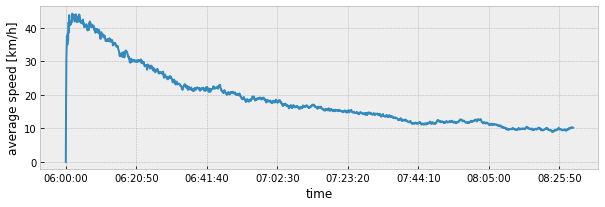

In [26]:
data.groupby('time').mean()['speed'].plot(figsize=(10,3), ylabel="average speed [km/h]");

**Vehicles spend half of their time at less than 30 km/h**

In [27]:
ID_speed_TS = pd.pivot_table(data, index='ID', columns='time', values='speed')
more_than_30 = ID_speed_TS.apply(lambda x: sum(x>30)/sum(x.notna()), axis=1)
print(F"Vehicles spend in average the {more_than_30.mean():.2%} of their time driving at more than 30 km/h speed")

Vehicles spend in average the 49.96% of their time driving at more than 30 km/h speed


**The most used lanes have an average speed lower than 10 km/h**

In [28]:
by_lane = data.groupby('lane_edge')

most_used = pd.DataFrame(by_lane['ID'].count().sort_values(ascending=False).head(15))
most_used.rename(columns={'ID': "n. vehicles"})

speed_by_lane = by_lane['speed'].mean()
most_used['mean speed'] = most_used.index.map(lambda x: speed_by_lane[x])

most_used

,ID,mean speed
lane_edge,,
152466#0_1,413336,0.144685
152649#1_1,294299,0.345245
152818#3_1,264382,0.253156
-152605#0_1,244588,0.437675
-152480_1,237558,0.517493
152896_1,230950,0.138940
152771_1,225676,0.245177
152824#1_1,202639,0.203132
152451_1,198459,0.217084


First of all, there is a lane that is exceeding by far all the others concerning the total number of vehicles using it.
And speaking about speeds, wow, they are actually close to 0! The finding is so striking that it's better to verify their max. speed too, to be sure nothing is wrong about them:

In [29]:
speed_by_lane = by_lane['speed'].max()
most_used['max. speed'] = most_used.index.map(lambda x: speed_by_lane[x])

most_used

,ID,mean speed,max. speed
lane_edge,,,
152466#0_1,413336,0.144685,51.372
152649#1_1,294299,0.345245,61.128
152818#3_1,264382,0.253156,59.868
-152605#0_1,244588,0.437675,62.640
-152480_1,237558,0.517493,63.324
152896_1,230950,0.138940,43.848
152771_1,225676,0.245177,58.428
152824#1_1,202639,0.203132,57.492
152451_1,198459,0.217084,62.928


Nothing weird, it just gets pretty congested in there...

**Are those lanes the same where we can find most vehicles _at the same time_?**

This is not really a hypothesis, but we want to understand if there are lanes where vehicles tend to be more equally distributed in time, thus allowing for less congested traffic conditions. If there are any, we may guess it should be the ones with the higher average speed.

In [30]:
edge_use_TS = pd.pivot_table(data, index='lane_edge', columns='time', values='ID', aggfunc='count')
most_crowded = edge_use_TS.max(axis=1).sort_values(ascending=False).head(15)
most_used['max. queue'] = most_used.index.map(lambda x: most_crowded[x] if x in most_crowded else np.nan)
most_used

,ID,mean speed,max. speed,max. queue
lane_edge,,,,
152466#0_1,413336,0.144685,51.372,511.0
152649#1_1,294299,0.345245,61.128,256.0
152818#3_1,264382,0.253156,59.868,337.0
-152605#0_1,244588,0.437675,62.640,293.0
-152480_1,237558,0.517493,63.324,288.0
152896_1,230950,0.138940,43.848,254.0
152771_1,225676,0.245177,58.428,273.0
152824#1_1,202639,0.203132,57.492,213.0
152451_1,198459,0.217084,62.928,243.0


Only one, and the one with the highest average speed, as we guessed. Thus, speed is not relly "high"... let's check its value for the number of simultaneous vehicles:

In [31]:
edge_use_TS.max(axis=1)[most_used[most_used['max. queue'].isna()].index]

lane_edge
-152814#4_1    130.0
dtype: float64

Indeed it is quite lower than the value of the other most used lanes. And what about if we think in terms of vehicle density (in vehicles/km)? For this we have to estimate the lane's length...

In [32]:
edge_l = by_lane['position'].max().apply(lambda x: float(x))
most_used["length"] = most_used.index.map(lambda x: edge_l[x])

most_used["max. density"] = most_used[['max. queue', 'length']].apply(lambda x: x[0]/(x[1]/1000), axis=1)
most_used

,ID,mean speed,max. speed,max. queue,length,max. density
lane_edge,,,,,,
152466#0_1,413336,0.144685,51.372,511.0,9.75,52410.256410
152649#1_1,294299,0.345245,61.128,256.0,99.85,2563.845769
152818#3_1,264382,0.253156,59.868,337.0,9.92,33971.774194
-152605#0_1,244588,0.437675,62.640,293.0,99.95,2931.465733
-152480_1,237558,0.517493,63.324,288.0,99.93,2882.017412
152896_1,230950,0.138940,43.848,254.0,9.85,25786.802030
152771_1,225676,0.245177,58.428,273.0,99.97,2730.819246
152824#1_1,202639,0.203132,57.492,213.0,9.89,21536.905966
152451_1,198459,0.217084,62.928,243.0,99.89,2432.675944


This is weird, the values seem a bit too high... as we could already have observed by noticing that there the longest queue contains more vehicles than the lane's meters!

**There are some lanes where congestions last more than 30' minutes**

In other words, we are assuming that, in the most congested edges, the average speed keeps staying lower than 5 km/h for more than 30' in a row.

In [33]:
edge_speed_TS = pd.pivot_table(data, index='lane_edge', columns='time', values='speed', aggfunc='mean')
edge_speed_TS.dropna(thresh=edge_speed_TS.shape[1]-30*60/5, inplace=True) # drop edges with less than 30' traffic
edge_speed_TS = edge_speed_TS.fillna(np.inf).applymap(lambda x: "F" if x>5 else "C")

get_longest_queue = lambda TS: max([len(Q) for Q in ''.join(TS).split('F')])
longest_queue_duration = lambda TS: (datetime.min+timedelta(seconds=5*(max(get_longest_queue(TS)-1, 0)))).time()

edge_speed_TS['max. queue duration'] = edge_speed_TS.apply(longest_queue_duration, axis=1)

In [34]:
worst_lanes = edge_speed_TS['max. queue duration'].sort_values(ascending=False).head(15)
worst_lanes

lane_edge
-152674#1_1    02:19:10
152896_1       02:18:45
152466#0_1     02:18:35
-153559#2_1    02:16:45
152818#3_1     02:16:00
152451_1       02:15:50
152796#0_1     02:15:40
152824#1_1     02:15:00
-152134_1      02:14:55
152832#1_1     02:14:45
152775#4_1     02:14:40
-152814#4_1    02:13:45
152771_1       02:11:25
-153480#7_1    02:10:10
152649#1_1     02:10:05
Name: max. queue duration, dtype: object

Wow, in the worse lane the average speed is lower than 5 km/h for almost all the time! Is it even in our table of most-used lanes? If not, let's look at its corresponding values:

In [35]:
if worst_lanes.index[0] not in most_used.index:
    print(F"Aggregate number of vehicles: {by_lane['ID'].count()['-152674#1_1']}")
    print(F"Average speed: {by_lane['speed'].mean()['-152674#1_1']:.3f} km/h")
    print(F"Max. speed: {by_lane['speed'].max()['-152674#1_1']:.2f} km/h")
    print(F"Max. number of vehicles per instant: {edge_use_TS.loc['-152674#1_1'].max():.0f}")

Aggregate number of vehicles: 78335
Average speed: 0.134 km/h
Max. speed: 38.63 km/h
Max. number of vehicles per instant: 77


Much less vehicles than the others, and still the lowest speeds!

**Vehicles that travel for half an hour or more spend most of their time waiting**

This can be seen as the converse for vehicles of the previous statement.

In [36]:
ID_speed_TS.dropna(thresh=ID_speed_TS.shape[1]-30*60/5, inplace=True) # drop IDs with less than 30' travel-time
ratio_t_queueing = ID_speed_TS.apply(lambda x: sum(x.dropna()<5)/len(x.dropna()), axis=1)
ratio_t_queueing.sort_values()

ID
pedestrian_3-1_721_tr        0.814839
pedestrian_3-1_3941_tr       0.821133
pedestrian_3-1_2806_tr       0.821721
pedestrian_3-1_1519_tr       0.822581
pedestrian_3-1_320_tr        0.823895
                               ...   
pedestrian_2-1_1290_tr       0.988656
pedestrian_2-1_2759_tr       0.988749
pedestrian_2-1_4901_tr       0.989056
pedestrian_1-1-veh_681_tr    0.989778
commercial_1-1_157           0.989835
Length: 1480, dtype: float64

Same as before, even worse than expected. Vehicles that queue most spend almost all their time in jams (almost 99 %)! Even those that queue less, if they travel at least half an hour then they still spend the 80 % of their time waiting!

**The number of vehicles stuck in traffic increases quadratically with time**

Given the speed values we saw before, it is right to assume that the formation of congestions is much faster that linear. Also, minutes seem to be a right choice for time, if we think in terms of a reasonable time-constant for the traffic process. 

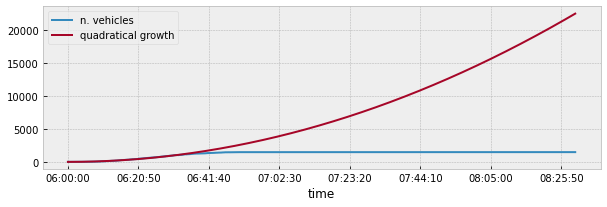

In [37]:
n_veh_queueing = pd.DataFrame(ID_speed_TS.apply(lambda x: sum(x.dropna()<5)), columns=["n. vehicles"])

get_minutes = lambda x: (datetime.strptime(x, '%H:%M:%S') - datetime(1900, 1, 1)).total_seconds()/60-360
base = list(n_veh_queueing.index.map(get_minutes))
n_veh_queueing['quadratical growth'] = [x**2 for x in base]

n_veh_queueing.plot(figsize=(10,3));

Oups, we didn't consider the network saturation; still, the approximation seems to effectively hold true before this happen. Let's zoom:

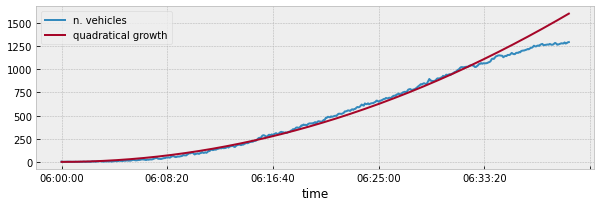

In [38]:
n_veh_queueing.loc[:'06:40:01'].plot(figsize=(10,3));

## Conclusions

We performed a data-driven analysis of a traffic process by looking at the features of vehicles and lanes. Before doing that, to be sure we were examining meaningful data, we had to refine the database itself to deal with a main issue: speed values inconsistent with the declared vehicle type.

We are now ready to take a step forward and apply some machine learning algorithms to make traffic predictions. Looking at the problem we faced, a natural application could be to implement a classification algorithm to automatically guess and assign the "correct" vehicle type. This will be the object of a further notebook.